In [1]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.cluster.hierarchy import linkage, dendrogram
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Clustering

## Load user profiles

In [2]:
user_profiles_filename = 'user_profiles_hospitality_dataset_2020.csv'

In [3]:
# read data
raw_data = pd.read_csv(f'./data/{user_profiles_filename}')
user_ids = raw_data['user_id']
del raw_data['user_id']
raw_data.head()

,9731_read,9731_likes,9731_posts,9731_comments,7174_read,7174_likes,7174_posts,7174_comments,12807_read,12807_likes,...,132077_posts,132077_comments,132078_read,132078_likes,132078_posts,132078_comments,50683_read,50683_likes,50683_posts,50683_comments
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Main pipeline

### Data pre-processing

In [4]:
raw_data.shape

(7767, 516)

In [5]:
# remove columns with only zeroes
# data = data.loc[:, (data != 0).any(axis=0)]
MIN_N_INTERACTIONS = 6
data = raw_data[raw_data.columns[raw_data.sum()>=MIN_N_INTERACTIONS]]
data.shape

(7767, 263)

In [6]:
preparation_pipe = Pipeline(steps=[
    ('normalization', Normalizer()), # normalization
    ('scaling', MinMaxScaler()), # scaling
])
transformed = preparation_pipe.fit_transform(data)
transformed_pca = PCA(n_components=200).fit_transform(transformed) # dimensionality reduction
transformed_pca.shape

(7767, 200)

In [7]:
print(f'Only positive values: {sum([val for val in pd.DataFrame(transformed_pca)[pd.DataFrame(transformed_pca) < 0.0 ].count()]) == 0}')

Only positive values: False


### Find users' cluster

In [8]:
NB_CLUSTERS = 15 # 129 streams

In [9]:
kmeans = KMeans(n_clusters=NB_CLUSTERS)
kmeans_labels = kmeans.fit_predict(transformed_pca)

In [10]:
spectral_clustering = SpectralClustering(n_clusters=NB_CLUSTERS, affinity='nearest_neighbors', assign_labels='kmeans')
spectral_clustering_labels = spectral_clustering.fit_predict(transformed_pca)

### Evaluation

In [11]:
print(f'Silhouette score for KMeans\' labels: {silhouette_score(transformed_pca, kmeans_labels)}')
print(f'Silhouette score for spectral clustering\'s labels: {silhouette_score(transformed_pca, spectral_clustering_labels)}')

Silhouette score for KMeans' labels: 0.36032385887694035
Silhouette score for spectral clustering's labels: 0.29354911365177006


In [12]:
print(f'Calinski Harabaz Index for KMeans\' labels: {calinski_harabasz_score(transformed_pca, kmeans_labels)}')
print(f'Calinski Harabaz Index for spectral clustering\'s labels: {calinski_harabasz_score(transformed_pca, spectral_clustering_labels)}')

Calinski Harabaz Index for KMeans' labels: 526.9734266732007
Calinski Harabaz Index for spectral clustering's labels: 324.87518928428193


### Clusters' properties

In [13]:
cluster_labels = kmeans_labels # spectral_clustering_labels

In [14]:
labelled_data = pd.DataFrame(preparation_pipe.fit_transform(raw_data), columns=raw_data.columns)
raw_columns = labelled_data.columns
labelled_data['label'] = cluster_labels

In [15]:
stats = ['mean', 'std', 'min', 'max']
main_feature = 'read'
y_values = {}

# restructure the dataset
for cluster_id in set(cluster_labels): # for each cluster
    y_values[cluster_id] = {}
    users_in_cluster = labelled_data[labelled_data['label'] == cluster_id] # get users from cluster = cluster_id
    for raw_col_name in raw_columns: # for each column in the dataframe
        feature = raw_col_name.split('_')[1] # find which feature this column "represents"
        for stat in stats: # for each stat to compute
            # compute the stat for the users of this cluster and the selected column
            if stat == 'mean':
                value = users_in_cluster[raw_col_name].mean()
            elif stat == 'std':
                value = users_in_cluster[raw_col_name].std()
            elif stat == 'min':
                value = users_in_cluster[raw_col_name].min()
            elif stat == 'max':
                value = users_in_cluster[raw_col_name].max()

            # add the stat to the dictionary
            if feature not in y_values[cluster_id].keys():
                y_values[cluster_id][feature] = {}
            if stat not in y_values[cluster_id][feature].keys():
                y_values[cluster_id][feature][stat] = []
            y_values[cluster_id][feature][stat].append(value)

In [16]:
stream_names, features = [set(var) for var in zip(*[col_name.split('_') for col_name in raw_data.columns])]
features.remove(main_feature)
features = [main_feature] + sorted(features) # sort features by name with first one being the "main feature"

### Clusters visualization

#### Radars

In [17]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, theta, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            return Circle((0.5, 0.5), 0.5)

        def _gen_axes_spines(self):
            return super()._gen_axes_spines()

    register_projection(RadarAxes)
    return theta

  0%|                                                                     | 0/15 [00:00<?, ?it/s]

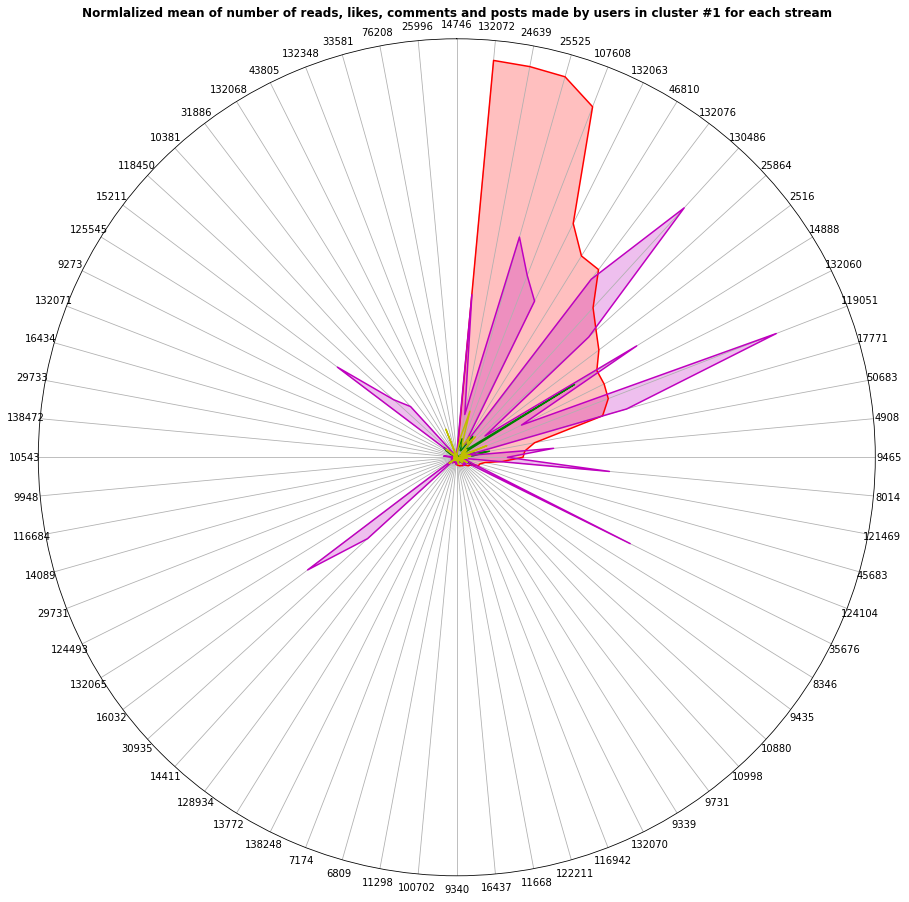

  7%|████                                                         | 1/15 [00:04<01:03,  4.50s/it]

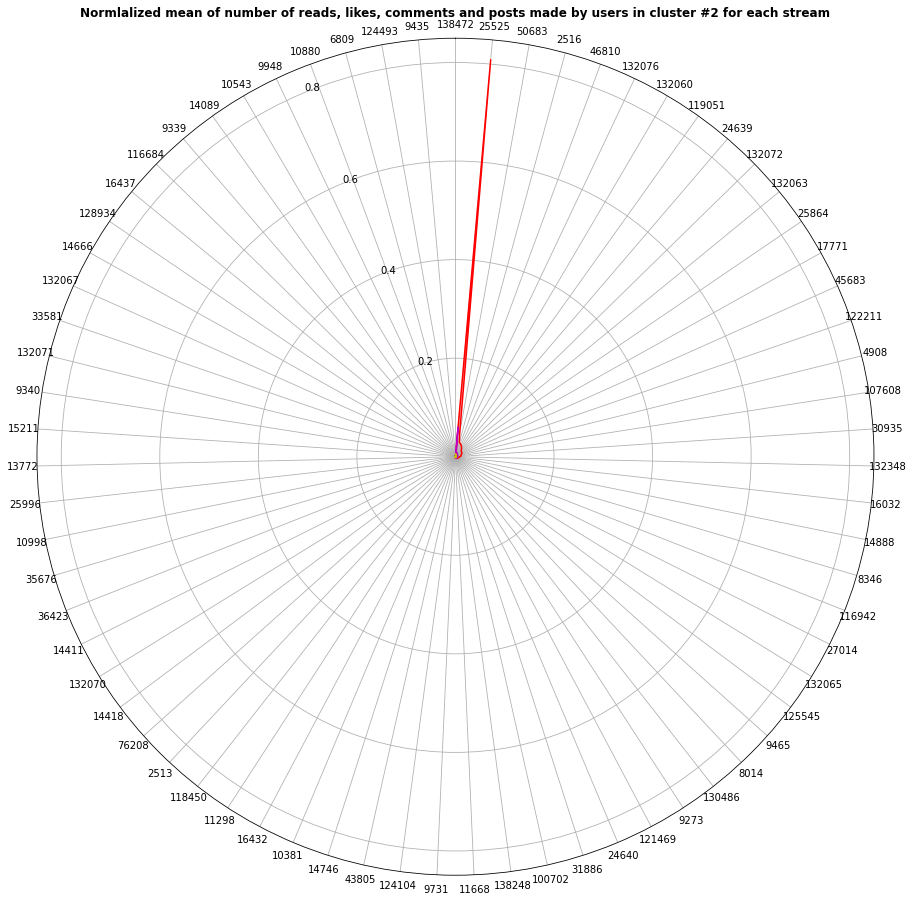

 13%|████████▏                                                    | 2/15 [00:09<00:58,  4.53s/it]

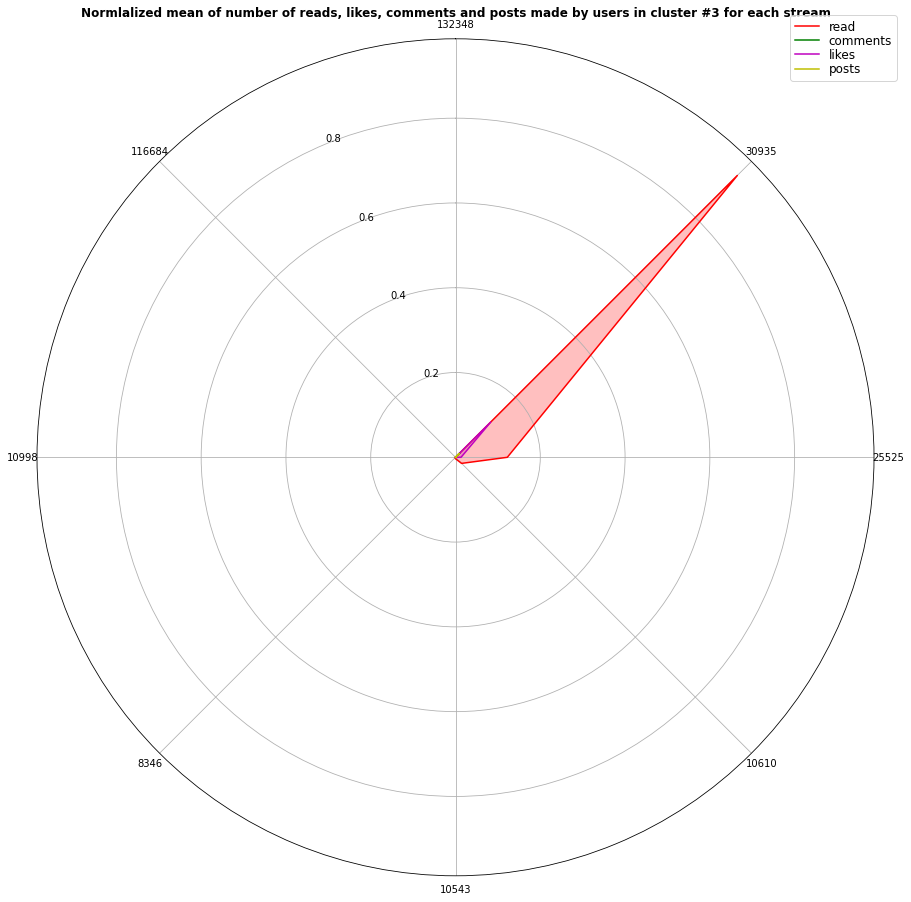

 20%|████████████▏                                                | 3/15 [00:09<00:39,  3.33s/it]

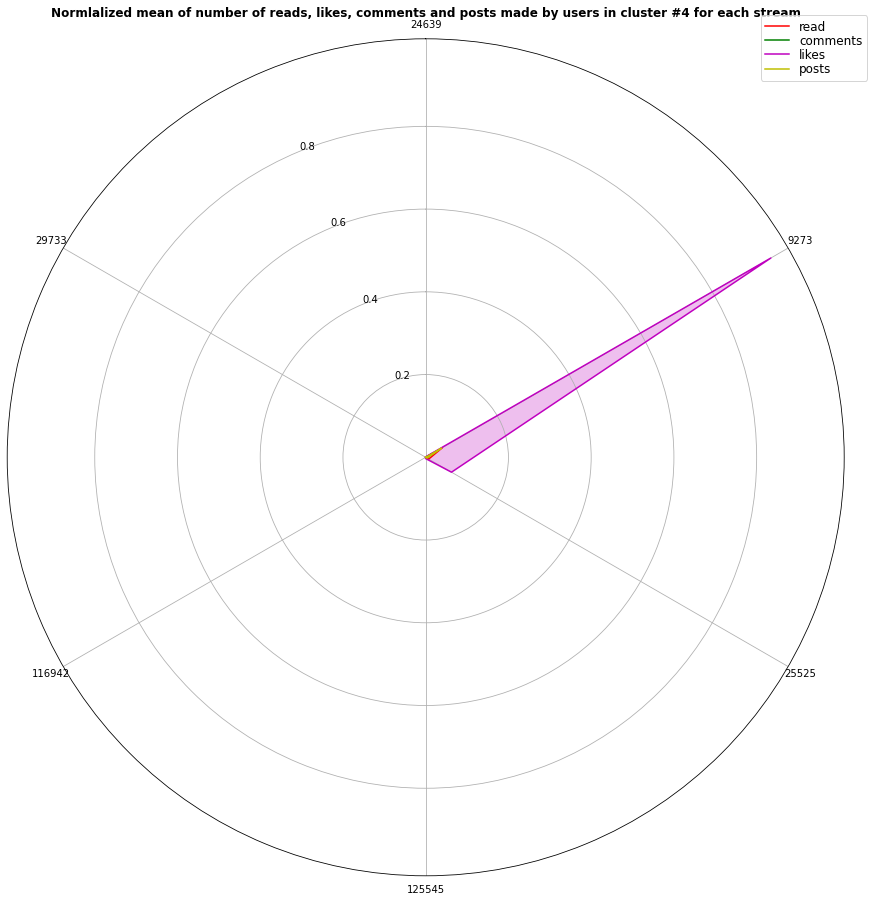

 27%|████████████████▎                                            | 4/15 [00:10<00:27,  2.47s/it]

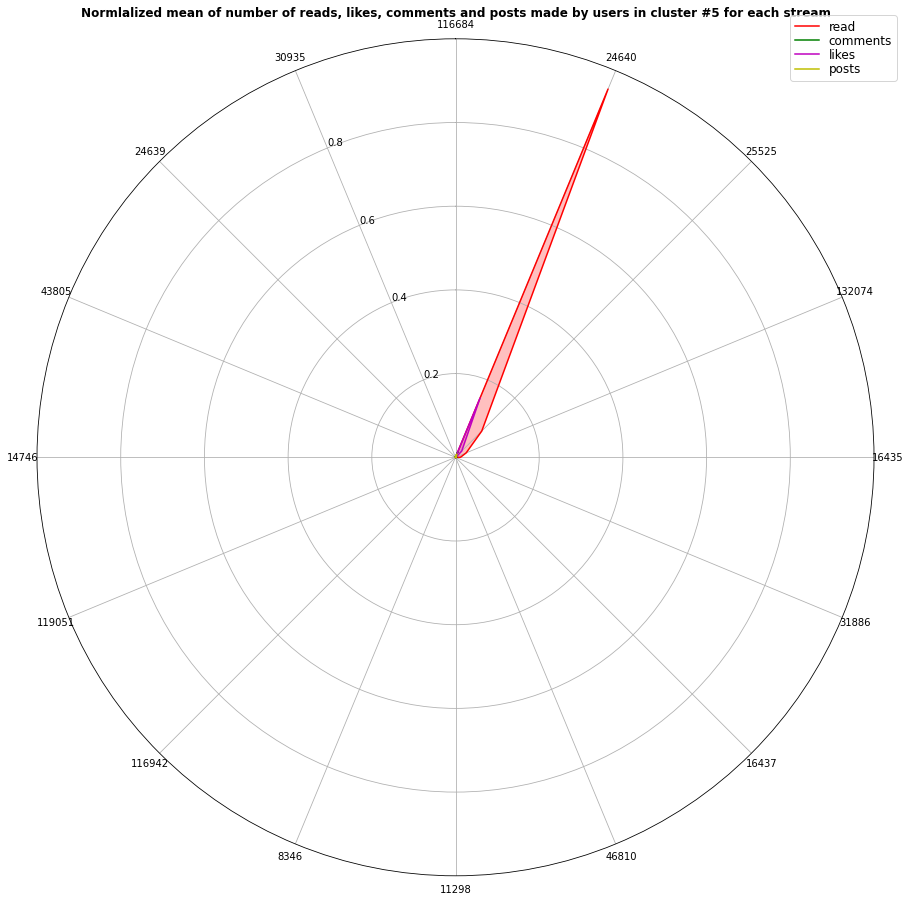

 33%|████████████████████▎                                        | 5/15 [00:10<00:19,  1.92s/it]

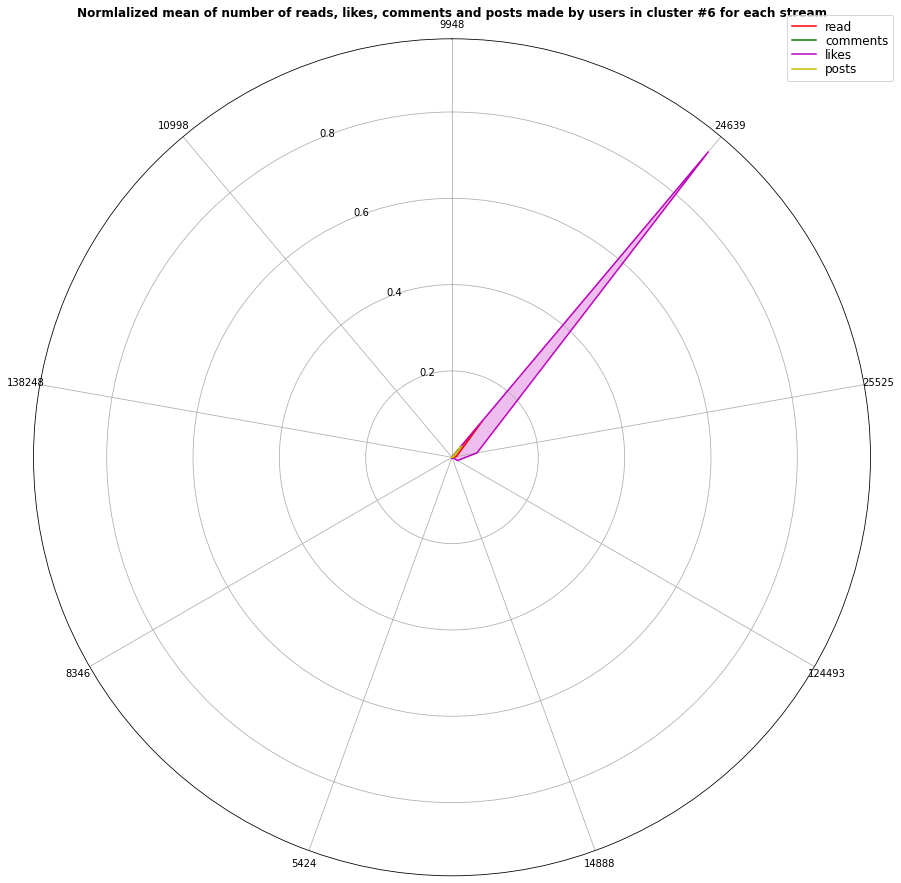

 40%|████████████████████████▍                                    | 6/15 [00:11<00:13,  1.50s/it]

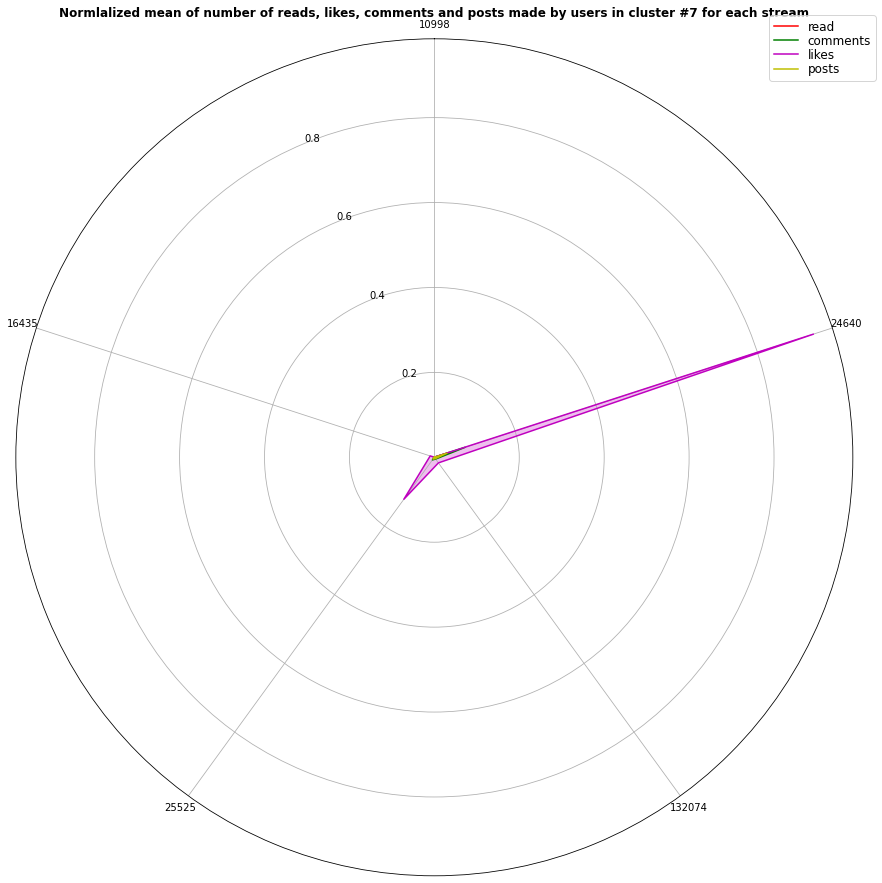

 47%|████████████████████████████▍                                | 7/15 [00:11<00:09,  1.19s/it]

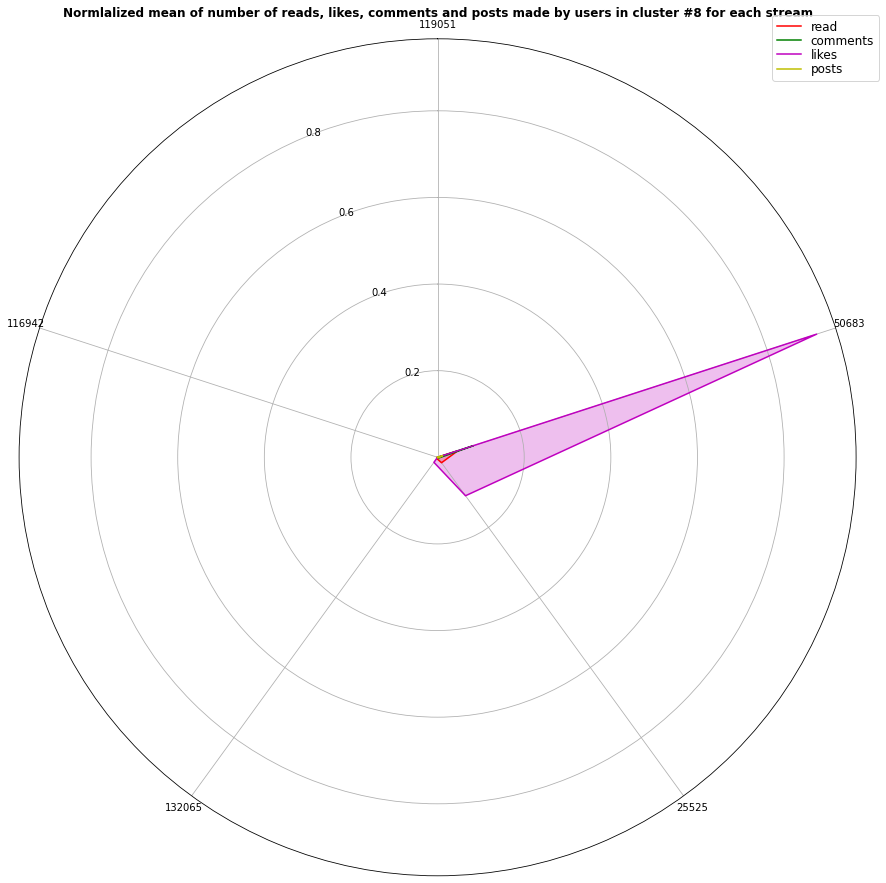

 53%|████████████████████████████████▌                            | 8/15 [00:12<00:06,  1.01it/s]

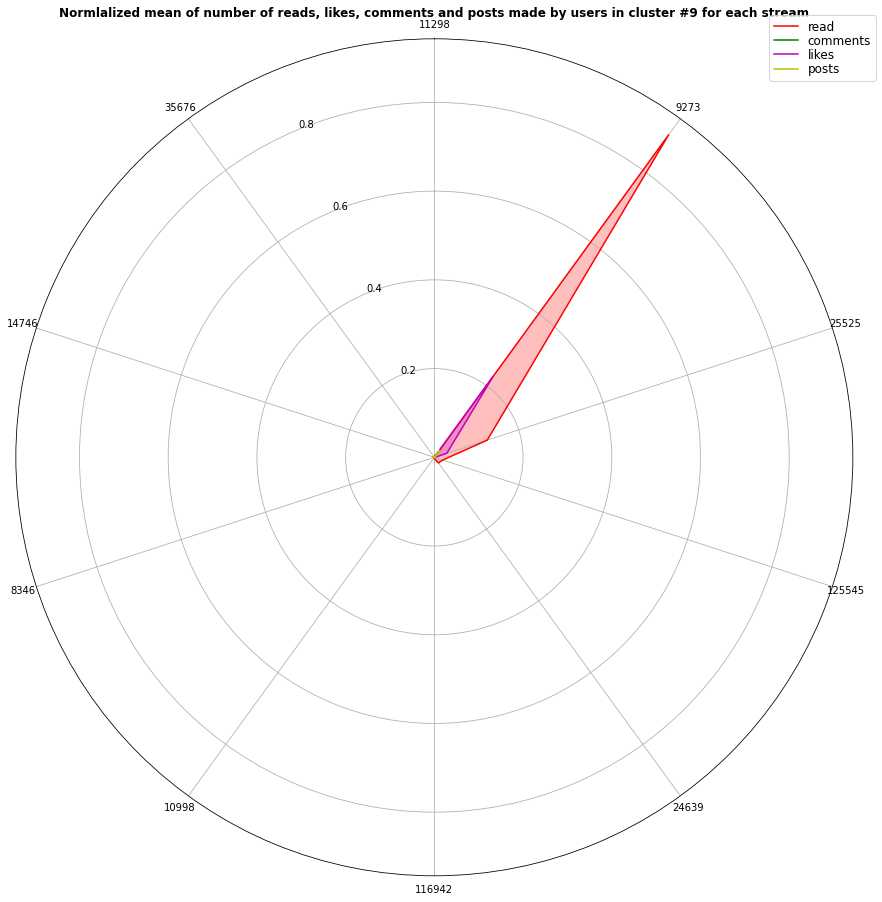

 60%|████████████████████████████████████▌                        | 9/15 [00:12<00:05,  1.17it/s]

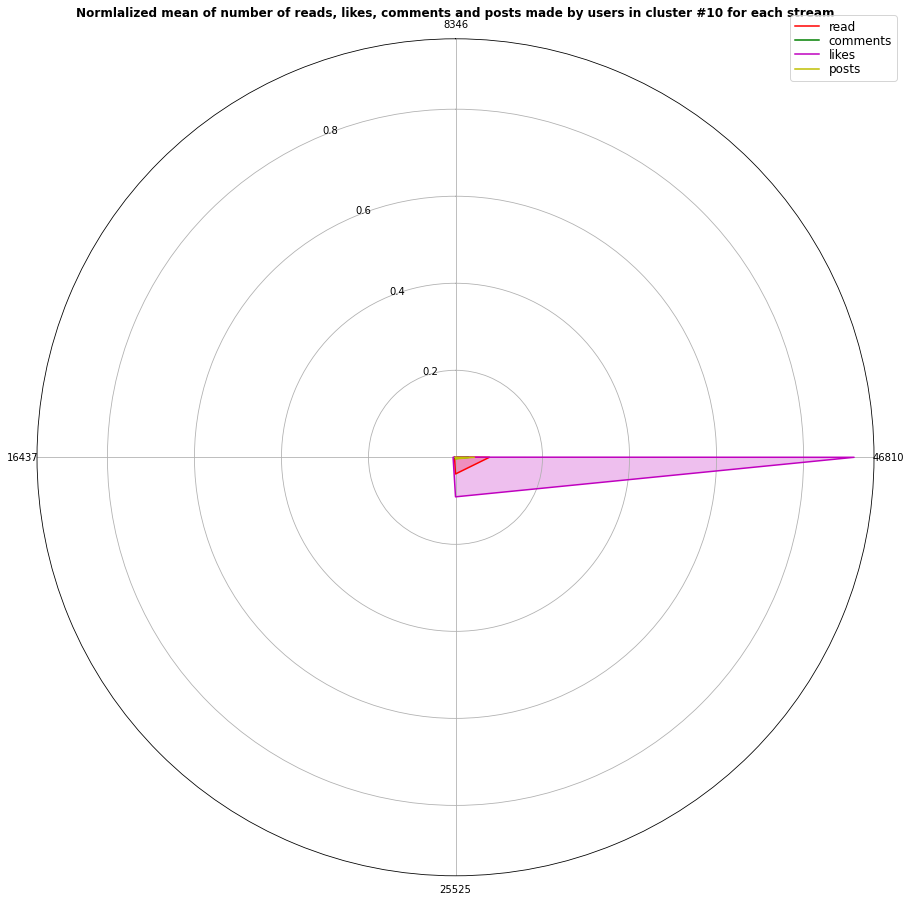

 67%|████████████████████████████████████████                    | 10/15 [00:13<00:03,  1.37it/s]

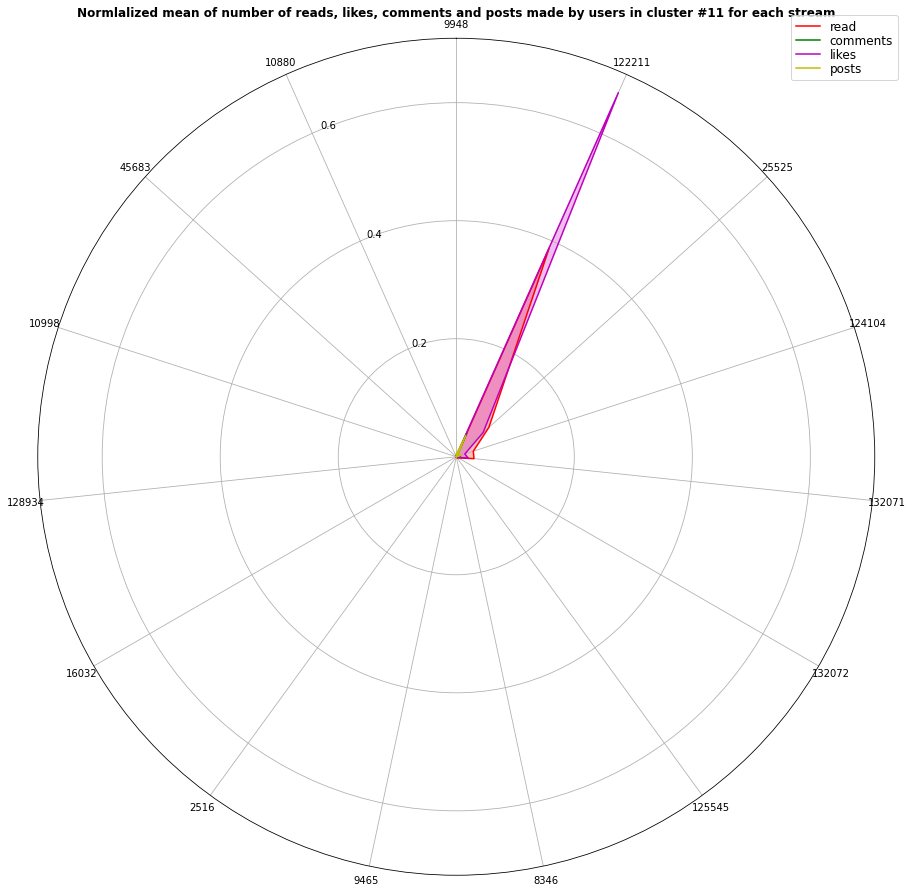

 73%|████████████████████████████████████████████                | 11/15 [00:13<00:02,  1.43it/s]

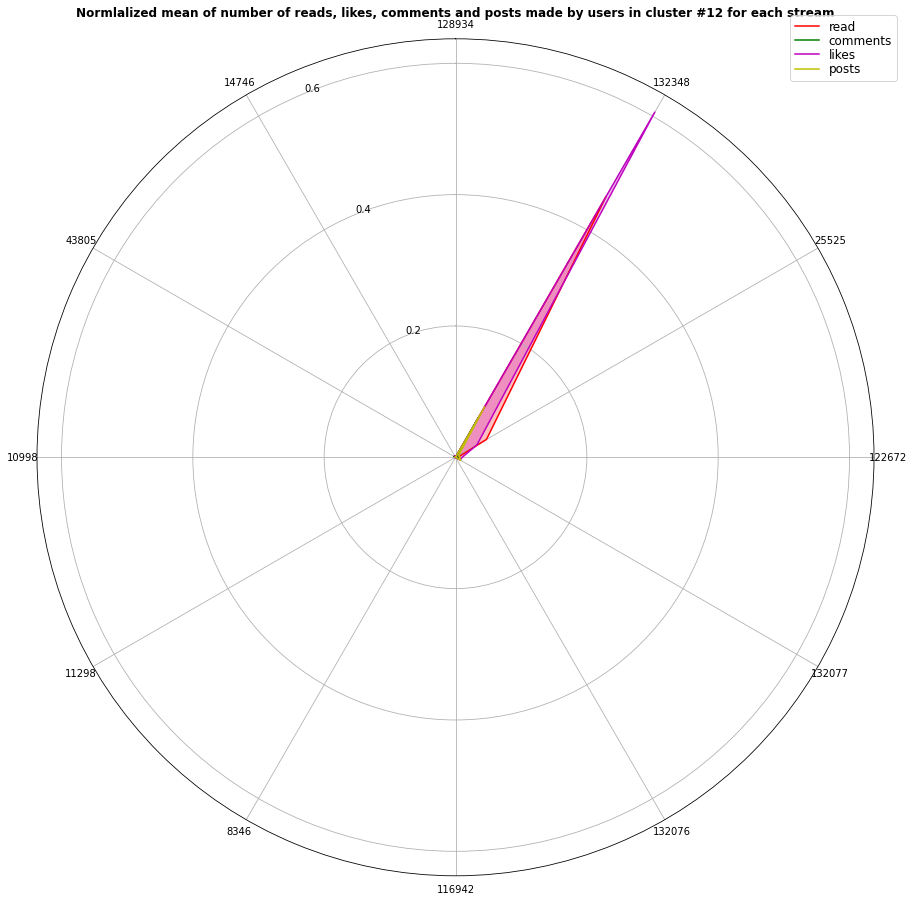

 80%|████████████████████████████████████████████████            | 12/15 [00:14<00:01,  1.52it/s]

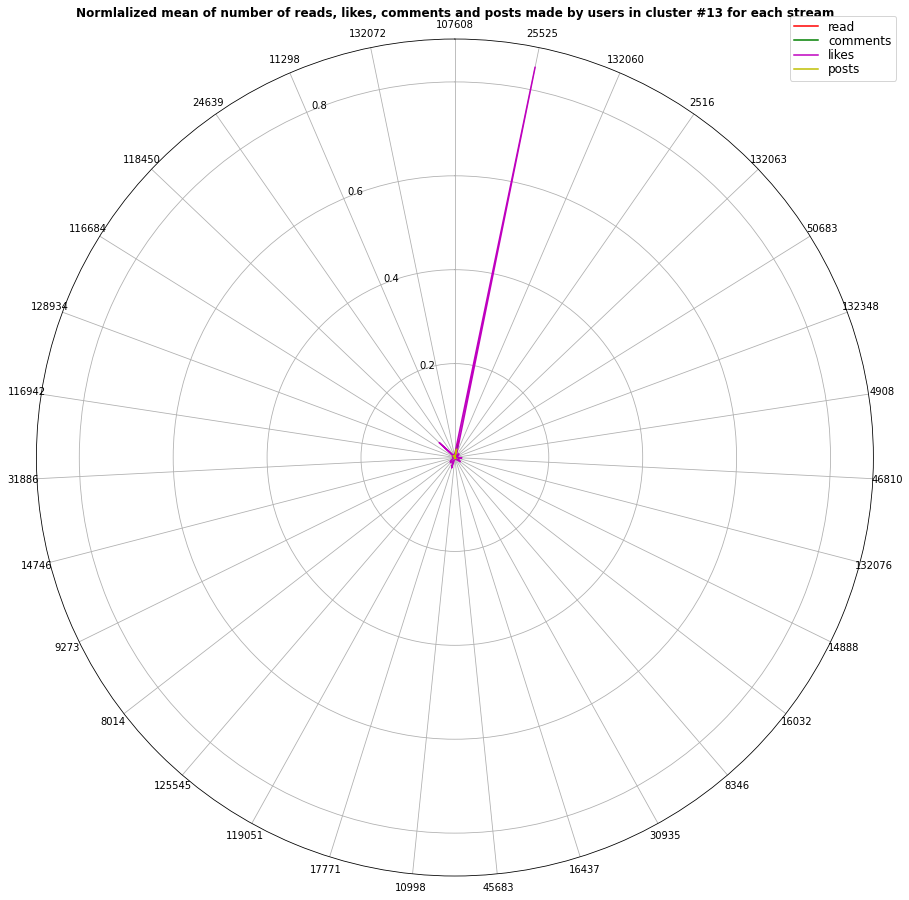

 87%|████████████████████████████████████████████████████        | 13/15 [00:15<00:01,  1.37it/s]

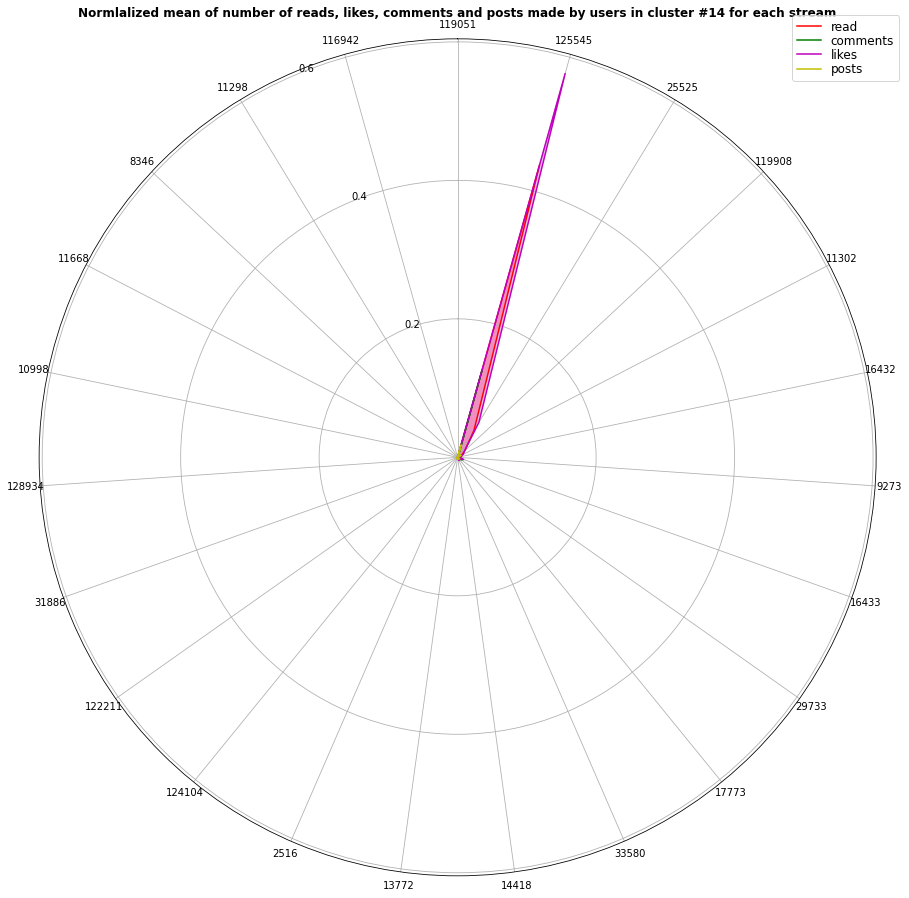

 93%|████████████████████████████████████████████████████████    | 14/15 [00:16<00:00,  1.36it/s]

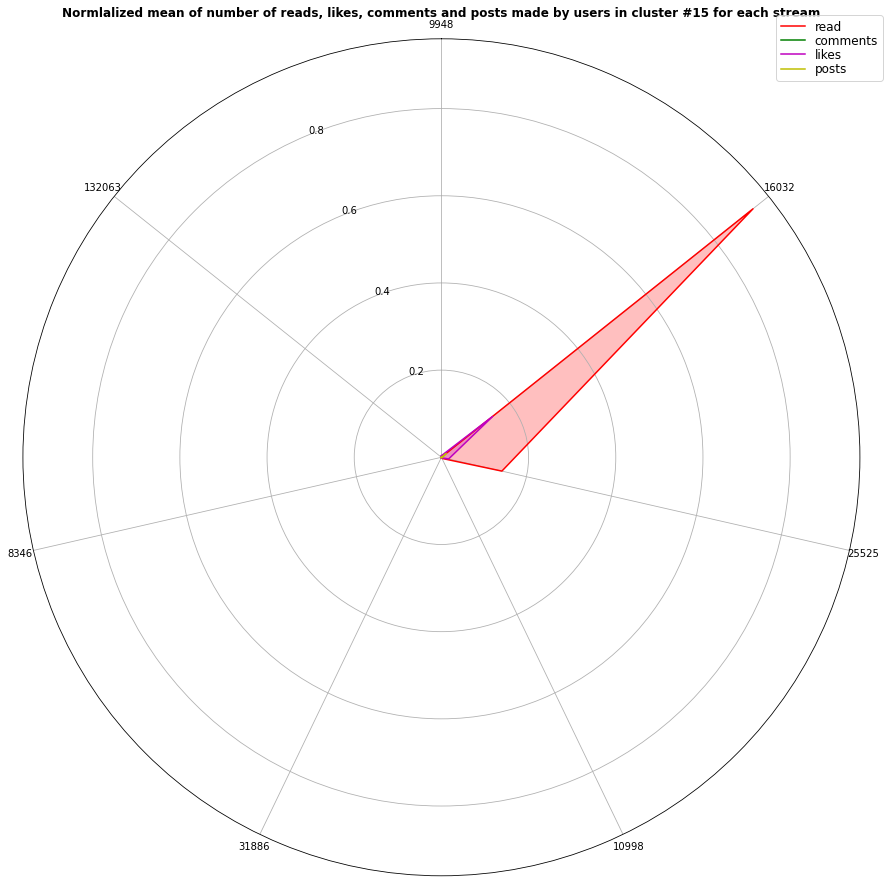

100%|████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.10s/it]

15 plotted clusters' signature
Clusters not plotted: []


In [18]:
# radar plots
xs = list(stream_names)
sort_streams_by_main_feature = True

stats_to_plot = ['mean'] # , 'std', 'min', 'max'
theta = radar_factory(len(xs))
clusters_not_plotted = []

for cluster_id in tqdm(set(cluster_labels)): # for each cluster
    
    # create plot's figures and axes
    fig, axes = plt.subplots(figsize=(15, 15), nrows=1, ncols=len(stats_to_plot), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['r', 'g', 'm', 'y']
    axes = np.array(axes) if type(axes) != 'numpy.ndarray' else axes
    for i, (ax, stat) in enumerate(zip(axes.flat, stats_to_plot)): # for each stat to plot
        
        plot_data = {'xs': xs[:], 'ys': {feature: y_values[cluster_id][feature][stat][:] for feature in features}}
        
        # rmv streams where the average reads and likes are 0
        indices_to_rmv = [i for i, (read_val, likes_val) in enumerate(zip(y_values[cluster_id]['read']['mean'], 
                                                                          y_values[cluster_id]['likes']['mean']))
                          if read_val <= 0 or likes_val <= 0]
        for i in indices_to_rmv[::-1]:
            plot_data['xs'].pop(i)
            for feature in features:
                plot_data['ys'][feature].pop(i)
                
        # sort streams by main feature values
        if sort_streams_by_main_feature:
            elems = list(zip(*sorted(zip(*[plot_data['ys'][feature] for feature in features], plot_data['xs']))))
            plot_data['xs'] = elems.pop(-1)
            plot_data['ys'] = {feature: elems[i] for i, feature in enumerate(features)}
        
        # plot
        if len(plot_data['xs']) > 2: # can't draw such a plot with less than 3 axes (streams)
            # set plot params
            ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
            ax.set_title(f'Normlalized {stat} of number of reads, likes, comments and posts made by users in cluster #{cluster_id+1} for each stream', 
                         weight='bold', size='large', position=(0.5, 1.1),  horizontalalignment='center', verticalalignment='center')

            # plot values
            theta = radar_factory(len(plot_data['xs']), frame='polygon')
            for ys, color in zip([plot_data['ys'][feature] for feature in features], colors): # for each feature
                ax.plot(theta, ys, color=color)
                ax.fill(theta, ys, facecolor=color, alpha=0.25)
            ax.set_varlabels(theta, plot_data['xs'])
            
            # plot legend
            if i == 0:
                labels = features
                legend = ax.legend(labels, loc=(0.9, .95),
                                   labelspacing=0.1, fontsize='large')
        else:
            clusters_not_plotted.append(cluster_id)
            plt.close(fig)
    plt.show()
print(f'{NB_CLUSTERS-len(clusters_not_plotted)} plotted clusters\' signature')
print(f'Clusters not plotted: {clusters_not_plotted}')

#### Matrices

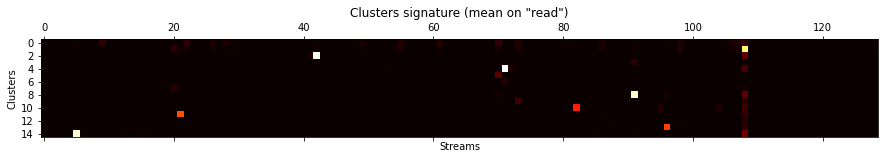

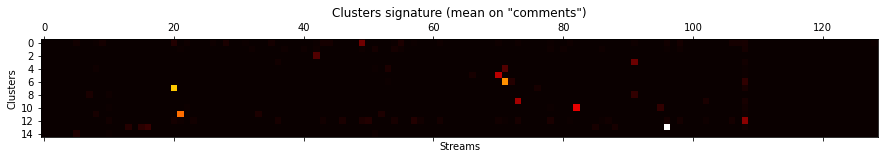

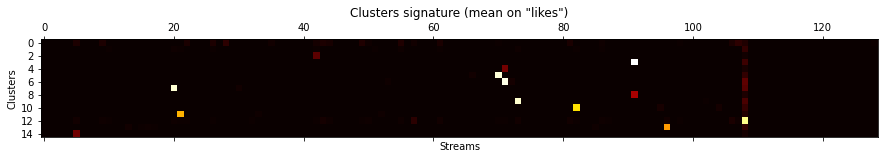

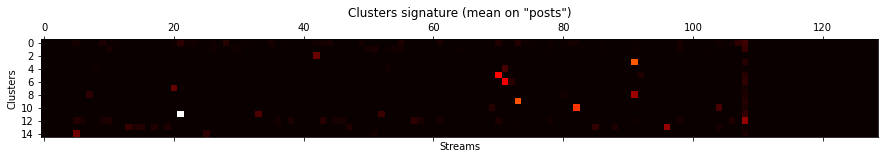

In [19]:
# clusters' signature plots
stats_to_plot = ['mean']

for stat in stats_to_plot:
    for feature in features:
        fig, ax = plt.subplots(figsize=(15, 15))

        matrix = np.array([y_values[cluster_id][feature][stat] for cluster_id in set(cluster_labels)])
        ax.matshow(matrix, cmap=plt.cm.hot)
        
        ax.set_title(f'Clusters signature ({stat} on "{feature}")')
        ax.set_ylabel('Clusters')
        ax.set_xlabel('Streams')

        #for i in range(len(matrix)):
        #    for j in range(len(matrix[i])):
        #        ax.text(i, j, str(matrix[i,j]), va='center', ha='center')

#### t-SNE

In [20]:
# run t-SNE
tsne = TSNE()
tsne_transformed = tsne.fit_transform(transformed)

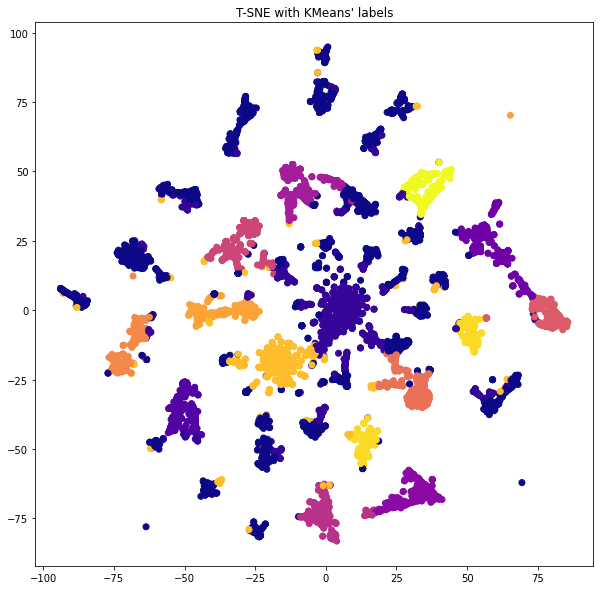

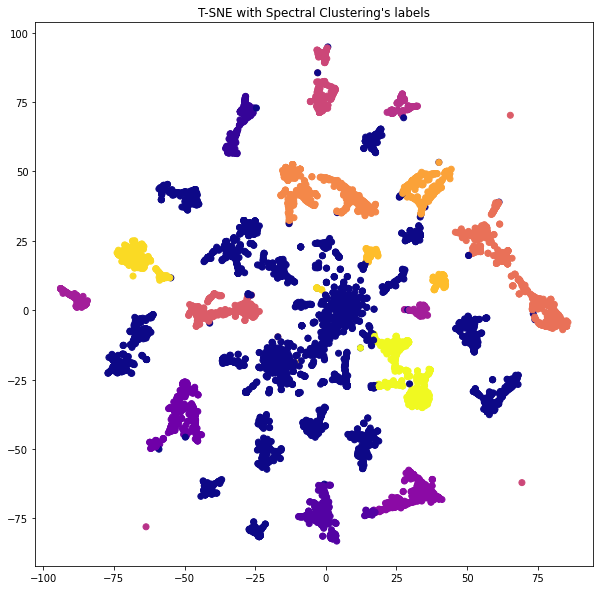

In [21]:
# plot t-SNE data visualization
x_axis = tsne_transformed[:, 0]
y_axis = tsne_transformed[:, 1]
fig_size = (10, 10)
cmap = plt.cm.plasma

for labels, title in [(kmeans_labels, 'T-SNE with KMeans\' labels'),
                      (spectral_clustering_labels, 'T-SNE with Spectral Clustering\'s labels')]:
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_title(title)
    ax.scatter(x_axis, y_axis, c=labels, cmap=cmap)